In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
# from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim import corpora
# from gensim.corpora import list2dict
from tqdm.notebook import tqdm # a progress bar tracker

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.max_columns', None)

### Data Extraction Transformation and Loading (ETL)

In [3]:
data = []
# mes = "message"
# match = re.match(r'^(\d{2}/\d{2}/\d{2}, \d{2}:\d{2} AM|PM - )')
with open('pycom_chat1.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        match = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}.*:(?= )))(.*)$', line)
        match_left = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(left)$)', line)
        match_add = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(added)(.*)$)', line)
        match_req = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(requested to join.)$)', line)
        match_joined = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined using this group\'s invite link)$)', line)
        match_join_frm_com = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined from the community)$)', line)
        match_pinned_mes = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(pinned a message)$)', line)
        match_change_num = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(Tap to message or add the new number.)$)', line)
        match_joined_by_my_invite = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined using your invite)$)', line)
        match_others_1 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(except when kept.)$)', line)
        match_others_2 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(disappearing messages.)$)', line)
        match_others_3 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((You removed)(.*)$)', line)
        match_others_4 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((Anyone in this group is now a community member)(.*)$)', line)
        match_others_5 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(changed to)(.*)$)', line)
        
        
        if match:
            global p1
            p1 = match.group(1)
            global p2
            p2 = match.group(4)
            global p3
            p3 = match.group(5)
            mes = "message"
        elif match_left:
            p1 = match_left.group(1)  
            p2 = match_left.group(6)
            p3 = match_left.group(7)
            mes = "left"
        elif match_add:
            p1 = match_add.group(1)  
            p2 = match_add.group(6)
            p3 = match_add.group(7)+" "+match_add.group(8)
            mes = "added"
        elif match_req:
            p1 = match_req.group(1)  
            p2 = match_req.group(6)
            p3 = match_req.group(7)
            mes = "join request"
        elif match_joined:
            p1 = match_joined.group(1)  
            p2 = match_joined.group(6)
            p3 = match_joined.group(7)
            mes = "joined"
        elif match_join_frm_com:
            p1 = match_join_frm_com.group(1)  
            p2 = match_join_frm_com.group(6)
            p3 = match_join_frm_com.group(7)
            mes = "joined"
        elif match_joined_by_my_invite:
            p1 = match_joined_by_my_invite.group(1)  
            p2 = match_joined_by_my_invite.group(6)
            p3 = match_joined_by_my_invite.group(7)
            mes = "joined"
        elif match_pinned_mes:
            p1 = match_pinned_mes.group(1)  
            p2 = match_pinned_mes.group(6)
            p3 = match_pinned_mes.group(7)
            mes = "pinned a message"
        elif match_change_num:
            p1 = match_change_num.group(1)  
            p2 = match_change_num.group(6)
            p3 = match_change_num.group(7)
            mes = "changed number"
        elif match_others_1:
            p1 = match_others_1.group(1)  
            p2 = match_others_1.group(6)
            p3 = match_others_1.group(7)
            mes = "others"
        elif match_others_2:
            p1 = match_others_2.group(1)  
            p2 = match_others_2.group(6)
            p3 = match_others_2.group(7)
            mes = "others"
        elif match_others_3:
            p1 = match_others_3.group(1)  
            p2 = match_others_3.group(6)
            p3 = match_others_3.group(7)
            mes = "others"
        elif match_others_4:
            p1 = match_others_4.group(1)  
            p2 = match_others_4.group(6)
            p3 = match_others_4.group(7)
            mes = "others"
        elif match_others_5:
            p1 = match_others_5.group(1)  
            p2 = match_others_5.group(6)
            p3 = match_others_5.group(7)+" "+match_others_5.group(8)
            mes = "others"
        else:
#             print(line)
            p3 += "\n"
            p3 += line
            mes = "message"
            data.pop()
        data.append([p1, p2, mes, p3])

df = pd.DataFrame(data, columns = ['datetime', 'name', 'type', 'detail'])

In [ ]:
import chardet
with open('pycom_chat1.txt', 'rb') as f:
    rez = chardet.detect(f.read())
    global charenc
    charenc = rez['encoding']
print(charenc)
with open('pycom_chat1.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        # match = re.match(r'^(\d{2}\/\d{2}\/\d{2}, \d{2}:\d{2} (AM|PM) -)((?<= ).*:(?= ))(.*)$', line)
        match = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(changed to)(.*)$)', line)
        
        if match:
            print(match.group(1))
            print(match.group(2))
            print(match.group(6))
            print(match.group(8))         

In [ ]:
with open('pycom_chat1.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        match = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}.*:(?= )))(.*)$', line)
        match_left = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(left)$)', line)
        match_add = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(added)(.*)$)', line)
        match_req = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(requested to join.)$)', line)
        match_joined = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined using this group\'s invite link)$)', line)
        match_join_frm_com = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined from the community)$)', line)
        match_pinned_mes = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(pinned a message)$)', line)
        match_change_num = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(Tap to message or add the new number.)$)', line)
        match_joined_by_my_invite = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(joined using your invite)$)', line)
        match_others_1 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(except when kept.)$)', line)
        match_others_2 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((.*)(disappearing messages.)$)', line)
        match_others_3 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((You removed)(.*)$)', line)
        match_others_4 = re.match(r'^(\d{1,2}\/\d{1,2}\/\d{1,2}, \d{1,2}:\d{1,2}\s{1}(AM|PM))(\s{1}-(\s{1}))((Anyone in this group is now a community member)(.*)$)', line)
        
        
        if match:
            global p1
            p1 = match.group(1)
            global p2
            p2 = match.group(4)
            global p3
            p3 = match.group(5)
            mes = "message"
        elif match_left:
            p1 = match_left.group(1)  
            p2 = match_left.group(6)
            p3 = match_left.group(7)
            mes = "left"
        elif match_add:
            p1 = match_add.group(1)  
            p2 = match_add.group(6)
            p3 = match_add.group(7)+" "+match_add.group(8)
            mes = "added"
        elif match_req:
            p1 = match_req.group(1)  
            p2 = match_req.group(6)
            p3 = match_req.group(7)
            mes = "join request"
        elif match_joined:
            p1 = match_joined.group(1)  
            p2 = match_joined.group(6)
            p3 = match_joined.group(7)
            mes = "joined"
        elif match_join_frm_com:
            p1 = match_join_frm_com.group(1)  
            p2 = match_join_frm_com.group(6)
            p3 = match_join_frm_com.group(7)
            mes = "joined"
        elif match_joined_by_my_invite:
            p1 = match_joined_by_my_invite.group(1)  
            p2 = match_joined_by_my_invite.group(6)
            p3 = match_joined_by_my_invite.group(7)
            mes = "joined"
        elif match_pinned_mes:
            p1 = match_pinned_mes.group(1)  
            p2 = match_pinned_mes.group(6)
            p3 = match_pinned_mes.group(7)
            mes = "pinned a message"
        elif match_change_num:
            p1 = match_change_num.group(1)  
            p2 = match_change_num.group(6)
            p3 = match_change_num.group(7)
            mes = "changed number"
        elif match_others_1:
            p1 = match_others_1.group(1)  
            p2 = match_others_1.group(6)
            p3 = match_others_1.group(7)
            mes = "others"
        elif match_others_2:
            p1 = match_others_2.group(1)  
            p2 = match_others_2.group(6)
            p3 = match_others_2.group(7)
            mes = "others"
        elif match_others_3:
            p1 = match_others_3.group(1)  
            p2 = match_others_3.group(6)
            p3 = match_others_3.group(7)
            mes = "others"
        elif match_others_4:
            p1 = match_others_4.group(1)  
            p2 = match_others_4.group(6)
            p3 = match_others_4.group(7)
            mes = "others"
        else:
            print(line)
            p3 += "\n"
            p3 += line
            mes = "message"

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  844 non-null    object
 1   name      844 non-null    object
 2   type      844 non-null    object
 3   detail    844 non-null    object
dtypes: object(4)
memory usage: 26.5+ KB


### Some more data cleaning and transformation

In [4]:
df["date"] = df["datetime"].str.split(', ').str[0]
df["time"] = df["datetime"].str.split(', ').str[-1]
df["date"] = pd.to_datetime(df.date)
df["time"] = pd.to_datetime(df.time)
df["time"] = df.time.dt.time
df["year"] = df.date.dt.year.astype('int')
df["month"] = df.date.dt.month
df["day"] = df.date.dt.day

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  844 non-null    object        
 1   name      844 non-null    object        
 2   type      844 non-null    object        
 3   detail    844 non-null    object        
 4   date      844 non-null    datetime64[ns]
 5   time      844 non-null    object        
 6   year      844 non-null    int32         
 7   month     844 non-null    int32         
 8   day       844 non-null    int32         
dtypes: datetime64[ns](1), int32(3), object(5)
memory usage: 49.6+ KB


In [6]:
total_count_of_engagements = df.name.count()
total_count_of_engagements

844

In [7]:
df.groupby('type').agg(no_of_engagements = ('date','count'))\
.sort_values('no_of_engagements', ascending=False)

,no_of_engagements
type,
message,613
joined,95
join request,94
left,17
added,11
pinned a message,6
others,5
changed number,3


In [5]:
df_messages = df[df.type == "message"]

In [6]:
# df_messages["hour"] = df_messages["time"].str.split(':').str[0]
df_messages["hours"] = df_messages.time
def time_to_hours(x):
    t = str(x)
    hour = t.split(":")[0]
    hour = int(hour)
    if hour < 4:
        return "0 - 3"
    elif hour < 7:
        return "4 - 6"
    elif hour < 10:
        return "7 - 9"
    elif hour < 13:
        return "10 - 12"
    elif hour < 16:
        return "13 - 15"
    elif hour < 19:
        return "16 - 18"
    elif hour < 22:
        return "19 - 21"
    else:
        return "22 - 23"   
df_messages.hours = df_messages.hours.apply(time_to_hours)

In [10]:
chat_by_month = df_messages.groupby(['year', 'month']).\
agg(No_of_engagements = ('date','count'))
chat_by_month



No_of_engagements
year month                   
2023 6                     44
     7                     76
     8                     62
     9                     47
     10                    52
     11                    15
     12                    15
2024 1                     20
     2                     81
     3                    132
     4                     62
     5                      7

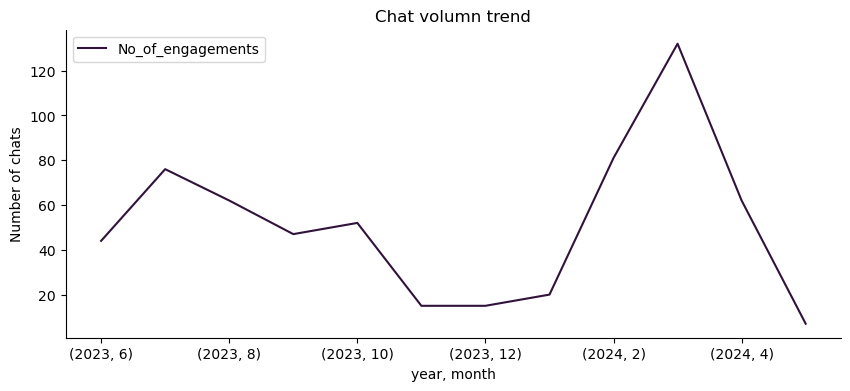

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
chat_by_month.plot(title="Chat volumn trend", xlabel="year, month",
                            ylabel="Number of chats", colormap = 'turbo', ax = ax)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

In [12]:
df_messages.groupby('name').agg(no_of_chats = ('date','count'))\
.sort_values('no_of_chats', ascending=False)

,no_of_chats
name,
~klemz:,231
Okeoma GeoStat:,66
Uzodimma PyCom:,34
Maggie ❤️:,31
Joe Ibe Pycom:,18
...,...
+234 904 157 9470:,1
Chijioke Larryson:,1
Charles I Pycom:,1


In [13]:
active_hours = df_messages.groupby('hours').agg(no_of_chats = ('date','count'))\
.sort_values('no_of_chats', ascending=False)
active_hours

,no_of_chats
hours,
19 - 21,139
10 - 12,135
7 - 9,118
16 - 18,82
13 - 15,65
22 - 23,46
4 - 6,19
0 - 3,9


In [7]:
df_joined = df[(df.type == "joined") | (df.type == "added")]

In [15]:
chat_by_month = df_joined.groupby(['year', 'month']).\
agg(No_of_engagements = ('date','count'))
chat_by_month

No_of_engagements
year month                   
2023 7                      3
     8                      5
     9                      3
     10                     3
     11                     1
     12                     1
2024 1                      1
     2                     29
     3                     39
     4                     18
     5                      3

In [167]:
# df.to_csv('python_gro_chat.csv', index = False)

In [169]:
# active_hours.to_csv('python_gro_active_hours.csv')

In [18]:
df_messages.columns

Index(['datetime', 'name', 'type', 'detail', 'date', 'time', 'year', 'month',
       'day', 'hours'],
      dtype='object')

In [8]:
df_msg_details = df_messages[["name", "detail"]]

In [10]:
rt = lambda x: re.sub("[^a-zA-Z]", ' ',str(x))
#replace anycharacter not a-zA-Z with white space

In [11]:
df_msg_details['detail'] = df_msg_details['detail'].map(rt)

In [12]:
df_msg_details['detail'] = df_msg_details['detail'].str.lower()

In [13]:
df_msg_details['detail'] = df_msg_details.detail.apply(lambda x: x.strip())
# To remove any whitespaces from front and back of string

In [14]:
df_msg_details['detail'] = df_msg_details.detail.apply(lambda x: simple_preprocess(x))
# To preprocess text data

In [16]:
# set stop words
stop_words = set(stopwords.words('english'))


In [17]:
# Define a function to remove stop words
def remove_stop_words(words):
    filtered_ = [word for word in words if word not in stop_words]
    return filtered_

In [18]:
# apply stop word removal
df_msg_details['detail'] = df_msg_details['detail'].apply(remove_stop_words)

In [19]:
# reate gensim dictionary
gen_dict = corpora.Dictionary(df_msg_details['detail'])

In [20]:
gen_corpus = [gen_dict.doc2bow(doc) for doc in df_msg_details['detail']]
# gen_corpus

In [21]:
# Train LDA topic
lda_model = LdaModel(corpus = gen_corpus, id2word=gen_dict, \
                     num_topics = 5, passes=15, random_state = 0)

In [22]:
# Extract topic as text
topic_as_text = []
for topic in lda_model.print_topics(num_words =5):
    # the number of words can be changed
    topic_as_text.append(topic[1])

topic_as_text

['0.017*"ai" + 0.011*"data" + 0.010*"https" + 0.009*"com" + 0.008*"message"',
 '0.029*"community" + 0.029*"everyone" + 0.024*"good" + 0.016*"us" + 0.012*"anambra"',
 '0.018*"https" + 0.015*"com" + 0.010*"program" + 0.010*"internship" + 0.009*"done"',
 '0.018*"challenge" + 0.015*"thank" + 0.009*"sir" + 0.007*"tech" + 0.007*"community"',
 '0.034*"media" + 0.033*"omitted" + 0.012*"python" + 0.012*"list" + 0.010*"resume"']

In [23]:
topic_as_text = [t.replace(' + ',',') for t in topic_as_text]

In [24]:
topic_as_text = [t.split(',') for t in topic_as_text]

In [25]:
topic_as_text

[['0.017*"ai"',
  '0.011*"data"',
  '0.010*"https"',
  '0.009*"com"',
  '0.008*"message"'],
 ['0.029*"community"',
  '0.029*"everyone"',
  '0.024*"good"',
  '0.016*"us"',
  '0.012*"anambra"'],
 ['0.018*"https"',
  '0.015*"com"',
  '0.010*"program"',
  '0.010*"internship"',
  '0.009*"done"'],
 ['0.018*"challenge"',
  '0.015*"thank"',
  '0.009*"sir"',
  '0.007*"tech"',
  '0.007*"community"'],
 ['0.034*"media"',
  '0.033*"omitted"',
  '0.012*"python"',
  '0.012*"list"',
  '0.010*"resume"']]

In [26]:
best_topics = []
for topics in topic_as_text:
    
    for t in topics:
        # match the topics only
        match_topics = re.match(r'(^(.*)(")(.*)(")(.*)$)', t)
        best_topics.append(match_topics.group(4))
#         print()
#         if match_topics:
#                 print(match_topics.group(4))
#         else:
#             print("no")
best_topics

['ai',
 'data',
 'https',
 'com',
 'message',
 'community',
 'everyone',
 'good',
 'us',
 'anambra',
 'https',
 'com',
 'program',
 'internship',
 'done',
 'challenge',
 'thank',
 'sir',
 'tech',
 'community',
 'media',
 'omitted',
 'python',
 'list',
 'resume']

In [27]:
# Extract Topic models
df_msg_details['topics'] = df_msg_details['detail'].apply(lambda x: lda_model[gen_dict.doc2bow(x)])

In [28]:
def topic_select(x):
    for t in x:
        if t[1] == max(x, key= lambda tp: tp[1])[1]:
            if t[0] == 0:
                return "Web Analytics and Data"
            elif t[0] == 1:
                return "Social Inclusion"
            elif t[0] == 2:
                return "Career Development"
            elif t[0] == 3:
                return "AI and Assistance"
            elif t[0] == 4:
                return "Python and monthly activities"

In [128]:
topic_list = ["web analytics and data", "social inclusion", \
              "career development", "AI and Assistance", "Python and monthly activities"]
topic_list

['web analytics and data',
 'social inclusion',
 'career development',
 'AI and Assistance',
 'Python and monthly activities']

In [29]:
df_msg_details['topic'] = df_msg_details['topics'].apply(topic_select)

In [30]:
Popular_topics = df_msg_details.groupby('topic').agg(no_of_times = ('name','count'))\
.sort_values('no_of_times', ascending=False)
Popular_topics

,no_of_times
topic,
Social Inclusion,199
Python and monthly activities,126
Web Analytics and Data,126
AI and Assistance,94
Career Development,68


In [115]:
# Popular_topics.to_csv('python_Popular_topics.csv')

In [ ]:
# Tokenize the text, splitting the texts into tokens using space as delimiter
# df_msg_details['tokenized'] = df_msg_details['detail'].str.split(' ')
# df_msg_details

In [ ]:
# Using NLTK to tokenize takes into consideration ponctuations and other special characters
df_msg_details['tokenized'] = df_msg_details['detail'].apply(word_tokenize)

In [51]:
df_msg_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        613 non-null    object 
 1   detail      613 non-null    object 
 2   neg         613 non-null    float64
 3   neu         613 non-null    float64
 4   pos         613 non-null    float64
 5   compound    613 non-null    float64
 6   tokenized2  613 non-null    object 
dtypes: float64(4), object(3)
memory usage: 33.6+ KB


In [31]:
def rejoin_words(list_):
    words = ' '.join([word for word in list_])
    return words


In [32]:
df_msg_details['detail_'] = df_msg_details['detail'].apply(rejoin_words)

In [33]:
for index, row in df_msg_details['detail_'].items():
    
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    
    if neg > pos:
        df_msg_details.loc[index, 'sentiment'] = 'Negative'
    elif pos > neg:
        df_msg_details.loc[index, 'sentiment'] = 'Posetive'
    else:
        df_msg_details.loc[index, 'sentiment'] = 'Neutral'

In [34]:
df_msg_details2 = df_msg_details[["name", "detail_", "sentiment"]]

In [123]:
# df_msg_details2.to_csv('python_gro_chat_sentiment.csv', index = False)

In [35]:
pos_chat = df_msg_details[df_msg_details.sentiment == 'Posetive']

In [37]:
posetive_words = ' '.join([word for word in pos_chat.detail_])

In [39]:
words_ = ' '.join([word for word in df_msg_details.detail_])

In [40]:
plt.figure(figsize=(20,14), facecolor='None')
wordcloud = WordCloud().generate(words_)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent word in posetive chat', fontsize=19)
plt.savefig('pos_chat.png1',format="png")
plt.show()

NameError: name 'WordCloud' is not defined

<Figure size 2000x1400 with 0 Axes>

Text(0.5, 1.0, 'Count of the sentiments')

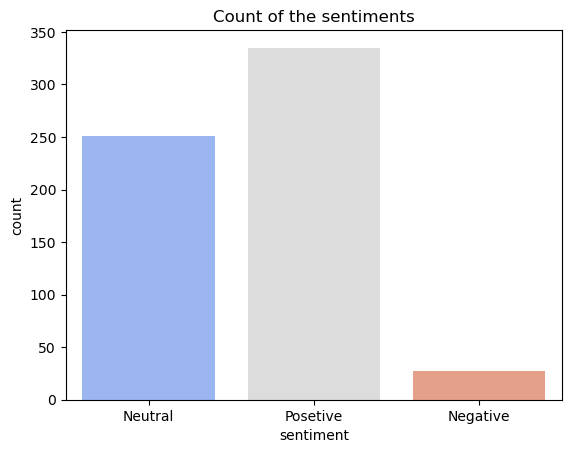

In [41]:
sns.countplot( x='sentiment', palette='coolwarm', data=df_msg_details).set_title('Count of the sentiments')